In [1]:
import numpy as np

import tanimoto_gp
from utils import bo, acq_funcs, get_data, GPCheckpoint
from utils.misc import init_gp

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

/home/wvir/miniconda3/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up Seaborn plotting style
sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

In [61]:
smiles_train, smiles_test, y_train, y_test = get_data.get_dockstring_dataset(target="PARP1")

n = len(smiles_train)

y_train, y_test = -y_train, -y_test

sampled_indices = np.random.choice(np.arange(10000), size=1000)
complement_indices = np.setdiff1d(np.arange(10000), sampled_indices)

X_init, y_init = smiles_train[sampled_indices], y_train[sampled_indices]
X, y = np.concatenate([smiles_train[complement_indices], smiles_test]), np.concatenate([y_train[complement_indices], y_test])

14.3

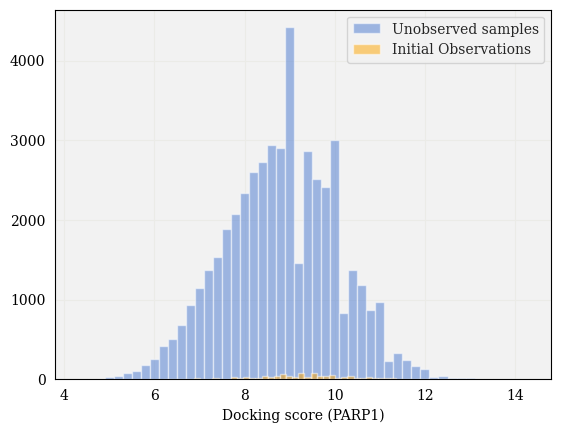

In [62]:
plt.hist(y, bins=50, alpha=0.5, label='Unobserved samples')
plt.hist(y_init, bins=50, color='orange', alpha=0.5, label='Initial Observations')

plt.xlabel("Docking score (PARP1)")

plt.legend();

In [18]:
with open('data/dockstring-bo/results-PARP1-sparse-r2.pkl', 'rb') as f:
        data_sparse = pickle.load(f)

with open('data/dockstring-bo/results-PARP1-compressed-r2.pkl', 'rb') as f:
        data_compressed = pickle.load(f)

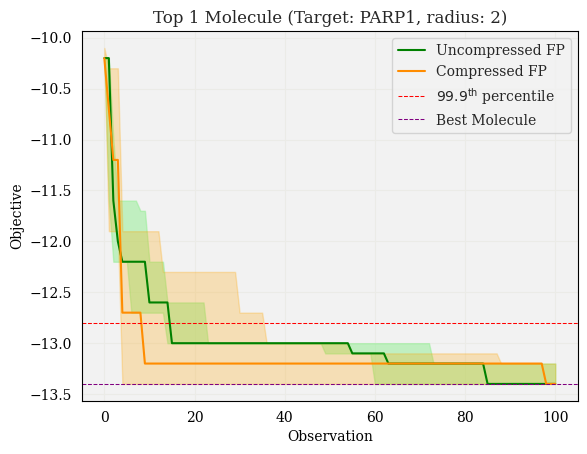

In [19]:
best_iter1, best_iter2, best_iter3 = data_sparse[0][0], data_sparse[1][0], data_sparse[2][0]
best_iter1_compressed, best_iter2_compressed, best_iter3_compressed = data_compressed[0][0], data_compressed[1][0], data_compressed[2][0]

best_all_iters = np.vstack([best_iter1, best_iter2, best_iter3])
best_all_iters_compressed = np.vstack([best_iter1_compressed, best_iter2_compressed, best_iter3_compressed])

best_median = - np.median(best_all_iters, axis=0)
best_max = - np.min(best_all_iters, axis=0)
best_min = - np.max(best_all_iters, axis=0)

best_median_compressed = - np.median(best_all_iters_compressed, axis=0)
best_max_compressed = - np.min(best_all_iters_compressed, axis=0)
best_min_compressed = - np.max(best_all_iters_compressed, axis=0)


# Plotting
xs = np.arange(len(best_median))

plt.plot(xs, best_median, color='green', label='Uncompressed FP')
plt.fill_between(xs, best_min, best_max, color='lightgreen', alpha=.5)

plt.plot(xs, best_median_compressed, color='darkorange', label='Compressed FP')
plt.fill_between(xs, best_min_compressed, best_max_compressed, color='orange', alpha=.25)

plt.axhline(percentile999, color='red', ls='dashed', lw=.75, label="$99.9^\\text{th}$ percentile")
plt.axhline(best_score, color='purple', ls='dashed', lw=.75, label='Best Molecule')

plt.xlabel("Observation")
plt.ylabel("Objective")
plt.title("Top 1 Molecule (Target: PARP1, radius: 2)")
plt.legend();

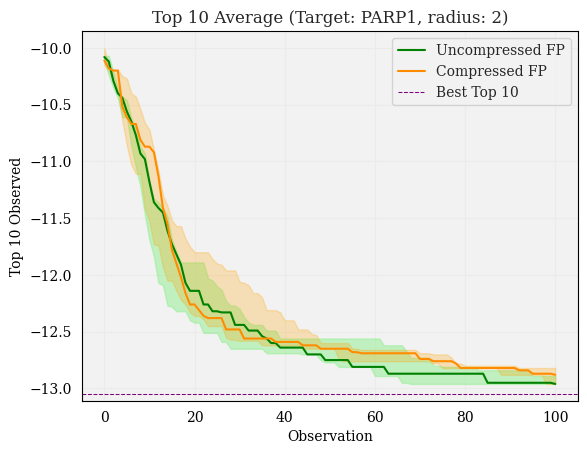

In [20]:
top10_iter1, top10_iter2, top10_iter3 = data_sparse[0][1], data_sparse[1][1], data_sparse[2][1]
top10_iter1_compressed, top10_iter2_compressed, top10_iter3_compressed = data_compressed[0][1], data_compressed[1][1], data_compressed[2][1]

top10_all_iters = np.vstack([top10_iter1, top10_iter2, top10_iter3])
top10_all_iters_compressed = np.vstack([top10_iter1_compressed, top10_iter2_compressed, top10_iter3_compressed])

top10_median = - np.median(top10_all_iters, axis=0)
top10_max = - np.min(top10_all_iters, axis=0)
top10_min = - np.max(top10_all_iters, axis=0)

top10_median_compressed = - np.median(top10_all_iters_compressed, axis=0)
top10_max_compressed = - np.min(top10_all_iters_compressed, axis=0)
top10_min_compressed = - np.max(top10_all_iters_compressed, axis=0)


# Plotting
xs = np.arange(len(top10_median))

plt.plot(xs, top10_median, color='green', label='Uncompressed FP')
plt.fill_between(xs, top10_min, top10_max, color='lightgreen', alpha=.5)

plt.plot(xs, top10_median_compressed, color='darkorange', label='Compressed FP')
plt.fill_between(xs, top10_min_compressed, top10_max_compressed, color='orange', alpha=.25)

plt.axhline(best_top10, color='purple', ls='dashed', lw=.75, label='Best Top 10')

plt.xlabel("Observation")
plt.ylabel("Top 10 Observed")
plt.title("Top 10 Average (Target: PARP1, radius: 2)")
plt.legend();

### Observations:

* This BO method frequently finds the best molecule. However, it never finds all of the top 10 molecules. Nevertheless, it consistently finds the same 10 molecules with an average docking score of ~-12.96. This leads me to believe that the same 10 molecules are consistently being found, and some of the top 10 molecules from the whole dataset are *never* being found

In [27]:
smiles_train, _, y_train, _ = get_data.get_dockstring_dataset(target='F2')

y_train = -y_train

percentile95 = - np.quantile(y_train, .95)
percentile99 = - np.quantile(y_train, .99)
percentile999 = - np.quantile(y_train, .999)

best_top10 = - bo.find_top10_avg(y_train)
best_score = - np.max(y_train)

cutoff = np.percentile(y_train, 80)
bottom_80_indices = np.where(y_train <= cutoff)[0]
sampled_indices = np.random.choice(bottom_80_indices, size=1000, replace=False)
bottom_80_complement = np.setdiff1d(bottom_80_indices, sampled_indices)
top_20_indices = np.where(y_train > cutoff)[0]
complement_indices = np.concatenate([bottom_80_complement, top_20_indices])

X_init, X, y_init, y = smiles_train[sampled_indices], smiles_train[complement_indices], y_train[sampled_indices], y_train[complement_indices]

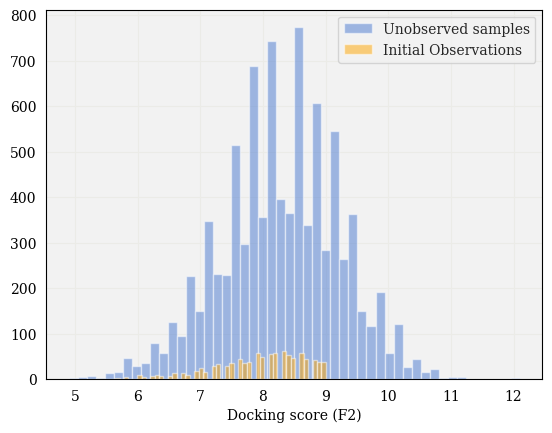

In [28]:
plt.hist(y, bins=50, alpha=0.5, label='Unobserved samples')
plt.hist(y_init, bins=50, color='orange', alpha=0.5, label='Initial Observations')

plt.xlabel("Docking score (F2)")

plt.legend();

In [34]:
with open('data/dockstring-bo/results-F2-sparse-r4.pkl', 'rb') as f:
        data_sparse = pickle.load(f)

# with open('data/dockstring-bo/results-F2-compressed-r4.pkl', 'rb') as f:
#         data_compressed = pickle.load(f)

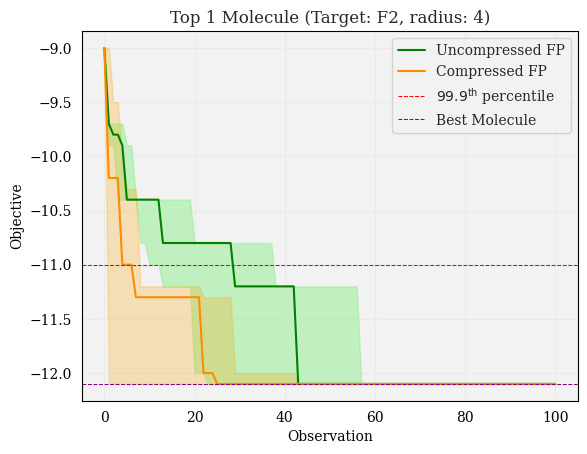

In [35]:
best_iter1, best_iter2, best_iter3 = data_sparse[0][0], data_sparse[1][0], data_sparse[2][0]
best_iter1_compressed, best_iter2_compressed, best_iter3_compressed = data_compressed[0][0], data_compressed[1][0], data_compressed[2][0]

best_all_iters = np.vstack([best_iter1, best_iter2, best_iter3])
best_all_iters_compressed = np.vstack([best_iter1_compressed, best_iter2_compressed, best_iter3_compressed])

best_median = - np.median(best_all_iters, axis=0)
best_max = - np.min(best_all_iters, axis=0)
best_min = - np.max(best_all_iters, axis=0)

best_median_compressed = - np.median(best_all_iters_compressed, axis=0)
best_max_compressed = - np.min(best_all_iters_compressed, axis=0)
best_min_compressed = - np.max(best_all_iters_compressed, axis=0)


xs = np.arange(len(best_median))

plt.plot(xs, best_median, color='green', label='Uncompressed FP')
plt.fill_between(xs, best_min, best_max, color='lightgreen', alpha=.5)

plt.plot(xs, best_median_compressed, color='darkorange', label='Compressed FP')
plt.fill_between(xs, best_min_compressed, best_max_compressed, color='orange', alpha=.25)

plt.axhline(percentile999, color='red', ls='dashed', lw=.75, label="$99.9^\\text{th}$ percentile")
plt.axhline(best_score, color='purple', ls='dashed', lw=.75, label='Best Molecule')

plt.xlabel("Observation")
plt.ylabel("Objective")
plt.title("Top 1 Molecule (Target: F2, radius: 4)")
plt.legend();

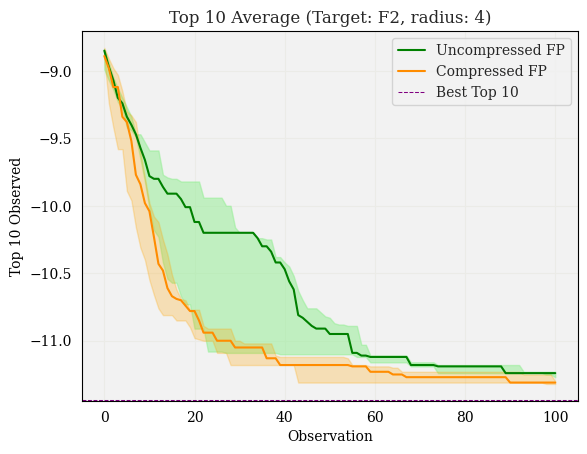

In [36]:
top10_iter1, top10_iter2, top10_iter3 = data_sparse[0][1], data_sparse[1][1], data_sparse[2][1]
top10_iter1_compressed, top10_iter2_compressed, top10_iter3_compressed = data_compressed[0][1], data_compressed[1][1], data_compressed[2][1]

top10_all_iters = np.vstack([top10_iter1, top10_iter2, top10_iter3])
top10_all_iters_compressed = np.vstack([top10_iter1_compressed, top10_iter2_compressed, top10_iter3_compressed])

top10_median = - np.median(top10_all_iters, axis=0)
top10_max = - np.min(top10_all_iters, axis=0)
top10_min = - np.max(top10_all_iters, axis=0)

top10_median_compressed = - np.median(top10_all_iters_compressed, axis=0)
top10_max_compressed = - np.min(top10_all_iters_compressed, axis=0)
top10_min_compressed = - np.max(top10_all_iters_compressed, axis=0)


xs = np.arange(len(top10_median))

plt.plot(xs, top10_median, color='green', label='Uncompressed FP')
plt.fill_between(xs, top10_min, top10_max, color='lightgreen', alpha=.5)

plt.plot(xs, top10_median_compressed, color='darkorange', label='Compressed FP')
plt.fill_between(xs, top10_min_compressed, top10_max_compressed, color='orange', alpha=.25)

plt.axhline(best_top10, color='purple', ls='dashed', lw=.75, label='Best Top 10')

plt.xlabel("Observation")
plt.ylabel("Top 10 Observed")
plt.title("Top 10 Average (Target: F2, radius: 4)")
plt.legend();

In [37]:
smiles_train, smiles_test, y_train, y_test = get_data.get_dockstring_dataset(target='PARP1')

In [39]:
y_train, y_test = -y_train, -y_test

In [ ]:


cutoff = np.percentile(y_train, 80)
bottom_80_indices = np.where(y_train <= cutoff)[0]
sampled_indices = np.random.choice(bottom_80_indices, size=1000, replace=False)
bottom_80_complement = np.setdiff1d(bottom_80_indices, sampled_indices)
top_20_indices = np.where(y_train > cutoff)[0]
complement_indices = np.concatenate([bottom_80_complement, top_20_indices])

X_init, X, y_init, y = smiles_train[sampled_indices], smiles_train[complement_indices], y_train[sampled_indices], y_train[complement_indices]

In [40]:
percentile95 = - np.quantile(y_train, .95)
percentile99 = - np.quantile(y_train, .99)
percentile999 = - np.quantile(y_train, .999)

best_top10 = - bo.find_top10_avg(y_train)
best_score = - np.max(y_train)

In [ ]:
sampled_indices = np.random.choice(np.arange(10000), size=1000)
complement_indices = np.setdiff1d(np.arange(10000), sampled_indices)

X_init, y_init = smiles_train[sampled_indices], y_train[sampled_indices]
X, y = np.concatenate([smiles_train[complement_indices], smiles_test]), np.concatenate([y_train[complement_indices], y_test])

In [ ]:
# Bottom 80:

# neg_docking_scores = -docking_scores

# cutoff = np.percentile(neg_docking_scores, 80)
# bottom_80_indices = np.where(neg_docking_scores <= cutoff)[0]
# sampled_indices = np.random.choice(bottom_80_indices, size=n_init, replace=False)
# bottom_80_complement = np.setdiff1d(bottom_80_indices, sampled_indices)
# top_20_indices = np.where(neg_docking_scores > cutoff)[0]
# complement_indices = np.concatenate([bottom_80_complement, top_20_indices])

# X, X_init, y, y_init = smiles[complement_indices], smiles[sampled_indices], neg_docking_scores[complement_indices], neg_docking_scores[sampled_indices]